In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
import sys
import glob
import time
import warnings
from datetime import datetime
print("Last updated on ", time.asctime())

Last updated on  Sun Mar 22 16:16:26 2020


In [14]:
import numpy as np
import pandas as pd
import matplotlib

In [15]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [16]:
from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d
from dataclasses import dataclass, field

In [17]:
import invisible_cities.core .fit_functions  as     fitf

In [18]:
def get_chi2(ydata, yfit, ndf, sigma):
    """
    Gets reduced chi2 and p-value

    Parameters
    ----------
    ydata : np.ndarray
        Data points.
    yfit : np.ndarray
        Fit values corresponding to ydata array.
    sigma : np.ndarray
        Data errors. If sigma is not given, it takes the poisson case:
            sigma = sqrt(ydata)
    ndf : int
        Number of degrees of freedom
        (number of data points - number of parameters).

    Returns
    -------
    chi2 : float
        Reduced chi2 computed as:
            chi2 = [sum(ydata - yfit)**2 / sigma**2] / ndf
    pvalue : float
        Fit p-value.
    """


    chi2   = np.sum(((ydata - yfit) / sigma)**2)

    if ndf > 0:
        return chi2 / ndf
    else:
        print(f'Warning in fit_functions_ic:chi2: ndf =0: chi2 = {chi2}')
        return chi2


In [19]:
path='/Users/jjgomezcadenas/Projects/Development/C19/data'
file = os.path.join(path,'COVID-19-Spain-2020-03-21.xlsx')
print(file)
df = pd.read_excel(file) 
df

/Users/jjgomezcadenas/Projects/Development/C19/data/COVID-19-Spain-2020-03-21.xlsx


,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId
0,21,3,2020,2833,235,Spain,NaN
1,20,3,2020,3431,169,Spain,NaN
2,19,3,2020,2538,107,Spain,NaN
3,18,3,2020,1987,182,Spain,NaN
4,17,3,2020,1438,21,Spain,NaN
5,16,3,2020,2000,152,Spain,NaN
6,15,3,2020,1522,15,Spain,NaN
7,14,3,2020,1227,37,Spain,NaN
8,13,3,2020,864,37,Spain,NaN
9,12,3,2020,501,12,Spain,NaN


In [20]:
d = datetime(year=2015, month=7, day=4)

In [21]:
d

datetime.datetime(2015, 7, 4, 0, 0)

In [22]:
def get_data_from_df(df, i0=0, i1=26):
    D  = df["Day"].iloc[i0:i1]
    M  = df["Month"].iloc[i0:i1]
    Y  = df["Year"].iloc[i0:i1] 
    C  = df["Cases"].iloc[i0:i1] 
    X  = df["Deaths"].iloc[i0:i1]
    
    DT = zip(Y.values, M.values, D.values )
    DTE = pd.Series([datetime(year=dt[0], month=dt[1], day=dt[2]) for dt in DT])
    cD = C.sort_index(ascending=False).cumsum()
    cX = X.sort_index(ascending=False).cumsum()
    return pd.concat([DTE,cD,cX], axis=1, keys=['Time','Cases','Dead'])


In [23]:
c19s = get_data_from_df(df)

In [24]:
c19s

,Time,Cases,Dead
0,2020-03-21,19978,1002
1,2020-03-20,17145,767
2,2020-03-19,13714,598
3,2020-03-18,11176,491
4,2020-03-17,9189,309
5,2020-03-16,7751,288
6,2020-03-15,5751,136
7,2020-03-14,4229,121
8,2020-03-13,3002,84
9,2020-03-12,2138,47


In [25]:
c19s.Time

0    2020-03-21
1    2020-03-20
2    2020-03-19
3    2020-03-18
4    2020-03-17
5    2020-03-16
6    2020-03-15
7    2020-03-14
8    2020-03-13
9    2020-03-12
10   2020-03-11
11   2020-03-10
12   2020-03-09
13   2020-03-08
14   2020-03-07
15   2020-03-06
16   2020-03-05
17   2020-03-04
18   2020-03-03
19   2020-03-02
20   2020-03-01
21   2020-02-29
22   2020-02-28
23   2020-02-27
24   2020-02-26
25   2020-02-25
Name: Time, dtype: datetime64[ns]

In [26]:
def pltf(C19, data='C', figsize=(12,12), linewidth=3):
    def formatter(ax):
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
    

    def reverse(s):
        return s.sort_index(ascending=False)
 
    fig = plt.figure(figsize=figsize)

    
    I = C19.Cases.values
    if data == 'D':
        I = C19.Dead.values
    X = C19.Time.values
    
    ax      = fig.add_subplot(3, 1, 1)
    plt.plot(X, I, linewidth=linewidth)
    formatter(ax)
    
    plt.xlabel('Date')
    plt.ylabel('Number of cases')
    plt.grid()
    
    ax      = fig.add_subplot(3, 1, 2)
    X = np.arange(len(C19.Time))
    I = reverse(C19.Cases).values
    if data == 'D':
        I = reverse(C19.Dead).values     
    
    plt.errorbar(X, I, fmt="kp", yerr= 0.05  * I, ms=7, ls='none')
    plt.xlabel('Date')
    plt.ylabel('Number of cases')
    plt.grid()
    
    ax      = fig.add_subplot(3, 1, 3)  
    ax.set_yscale('log')
    
    plt.errorbar(X, I, fmt="kp", yerr= 0.05  * I, ms=7, ls='none')
    plt.xlabel('Date')
    plt.ylabel('Number of cases')
    plt.grid()
    
    plt.tight_layout()
    plt.show()


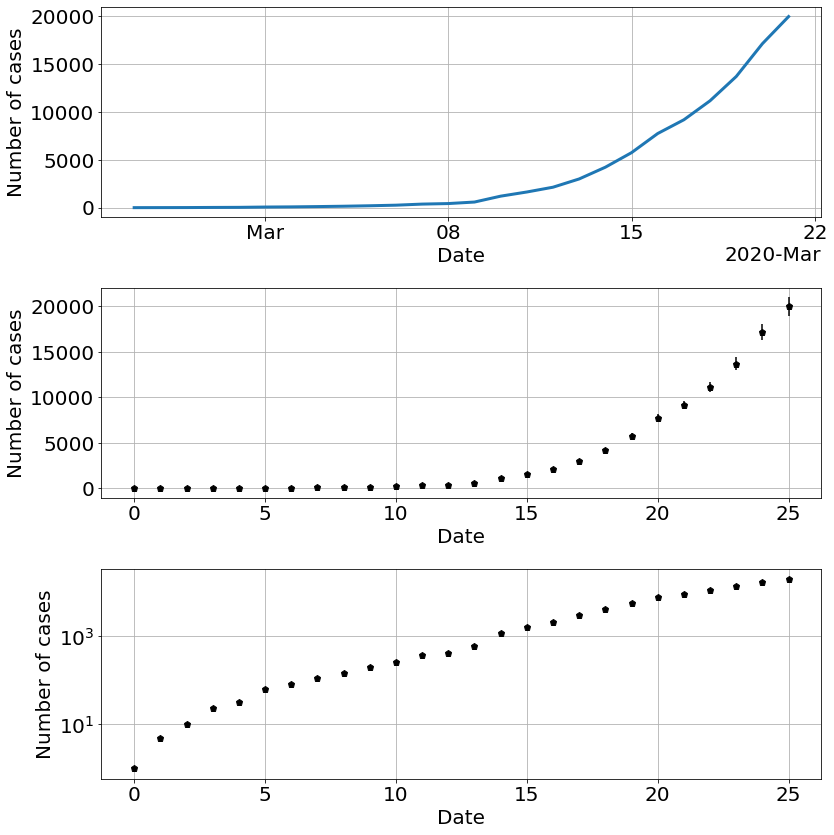

In [27]:
pltf(c19s, data='C', figsize=(12,12))

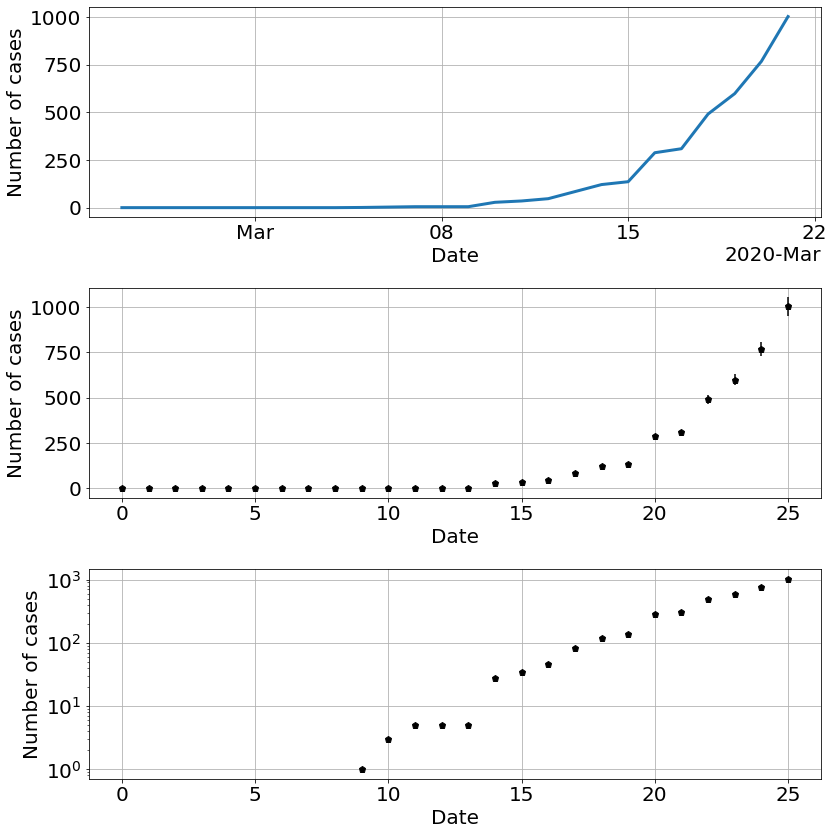

In [28]:
pltf(c19s, data='D', figsize=(12,12))

In [32]:
def pltfit(C19, imin=5, imax=26, re=0.05, data='Cases', figsize=(12,12), linewidth=3, ms=7):
    def reverse(s):
        return s.sort_index(ascending=False)
 
    def geti(C19):
        return np.log(reverse(C19[data]).values[imin:imax])
    
    fig = plt.figure(figsize=figsize)
    
    I = geti(C19)  
    X = np.arange(len(I))
    
    pf = np.polyfit(X, I, 1)
    print(f'coefficients of poly fit: {pf}')
    ft = np.poly1d(pf)
    sigma = re  * I
    
    plt.errorbar(X, I, fmt="kp", yerr= re  * I, ms=ms, ls='none')
    plt.plot(X, ft(X), linewidth=linewidth)
    plt.xlabel('Date in days')
    plt.ylabel('Number of cases')
    plt.grid()
    return pf, get_chi2(I, ft(X), len(I), sigma)

    

coefficients of poly fit: [0.30649083 4.13645703]


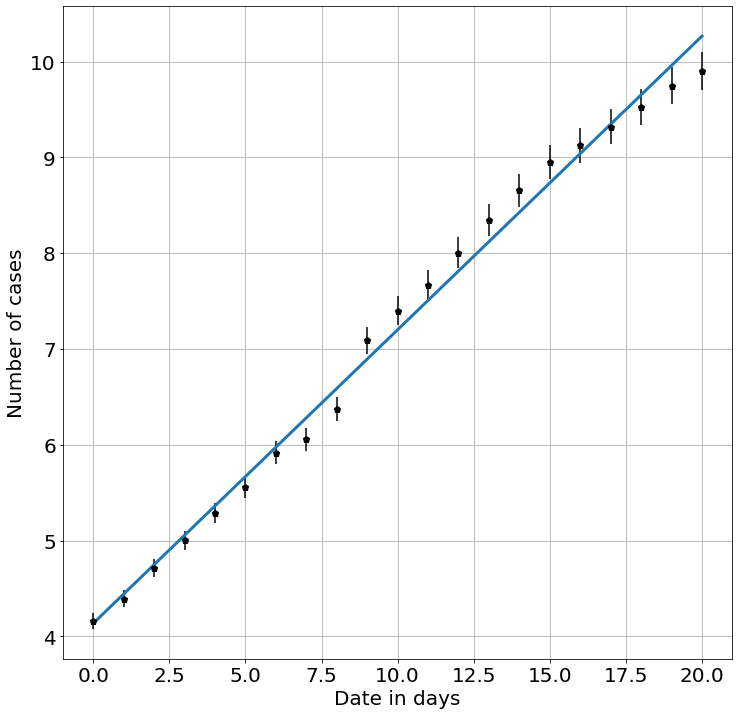

In [33]:
pf, chi2 = pltfit(c19s, imin=5, imax=26, re=0.02, data='Cases', figsize=(12,12), linewidth=3, ms=7)

In [36]:
print(f'duplication time = {1/pf[1]}')

duplication time = 0.24175278342482717


In [ ]:
za    = np.polyfit(fbib.W, fbib.I, 1)
print(f'coefficients of poly fit: {za}')

In [122]:
def expo_seed(x, y, eps=1e-12):
    """
    Estimate the seed for a exponential fit to the input data.
    """
    x, y  = zip(*sorted(zip(x, y)))
    const = y[0]
    slope = (x[-1] - x[0]) / np.log(y[-1] / (y[0] + eps))
    seed  = const, slope
    return seed

In [142]:
def fit_intensity(C19, data='C', ferr = 0.05, imax=3e+4, figsize=(10,10)):
    def reverse(s):
        return s.sort_index(ascending=False)

    y0 = reverse(C19.C).values
    print(y0)
    I = y0[25:50]
    print(I)
    X = np.arange(len(I))
    yerr= ferr  * I
    seed = expo_seed(X, I)
    f    = fitf.fit(fitf.expo, X, I, seed, sigma= yerr)
    fig = plt.figure(figsize=figsize)
    plt.errorbar(X,I, fmt="kp", yerr= yerr, ms=7, ls='none')
    plt.plot(X, f.fn(X), lw=3)
    
    #plt.ylim(0,imax)
    plt.xlabel('shot number')
    plt.ylabel('I (a.u.)')
    plt.show()
    print(f'Fit function -->{f}')
    return f.values, f.errors

[    1     1     1     1     1     1     1     1     1     2     2     2
     2     2     2     2     2     2     2     2     2     2     2     2
     3     7    12    25    34    66    83   114   151   200   261   374
   430   589  1204  1639  2140  3004  4231  5753  7753  9191 11178 13716
 17147 19980]
[    7    12    25    34    66    83   114   151   200   261   374   430
   589  1204  1639  2140  3004  4231  5753  7753  9191 11178 13716 17147
 19980]


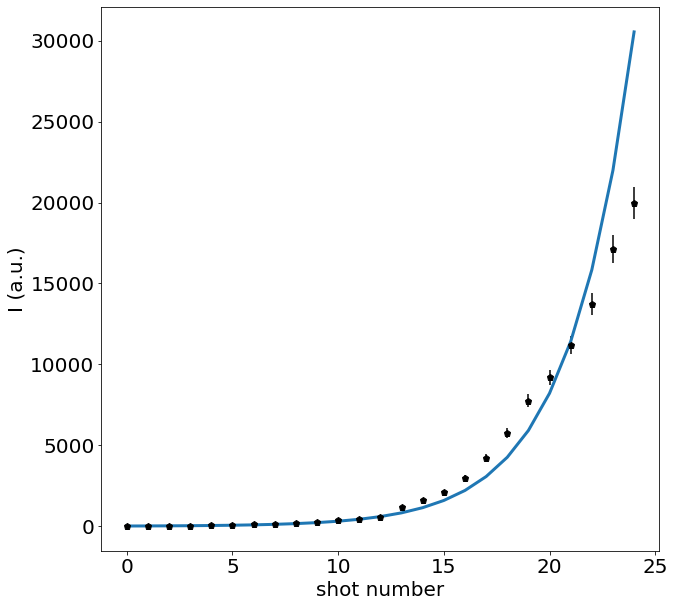

Fit function -->FitFunction(fn=<function fit.<locals>.<lambda> at 0x181c6f7b90>, values=array([11.55615939,  3.04580543]), errors=array([0.20626911, 0.01110921]), chi2=33.10034706076422, pvalue=5.202716091237219e-146, cov=array([[0.04254694, 0.00186194],
       [0.00186194, 0.00012341]]))


(array([11.55615939,  3.04580543]), array([0.20626911, 0.01110921]))

In [143]:
fit_intensity(c19s)